# Doc2Vec: Hate Speech Detection
#### Tweetからのヘイトスピーチ検出

![title](https://tr2.cbsistatic.com/hub/i/r/2016/09/23/62ce0973-6123-49ef-8b04-987f11461855/resize/770x/483e69e9661155caf2abe04c7dcad51d/candidatesentiment.png)

## MY GOAL   
### Twitterから人種差別や性別差別を含むヘイトスピーチを自動で発見するソフトウェアを作る   

### Motivation     
昨今、SNSなどが
Twitterから人種差別や性別差別に関わるヘイトスピーチを発見する学習モデルを構築します。   
これによりフェイクニュースなどを発見し排除するために機械学習などが使われています。   

## 1. 【データ概要】Import your Data

In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option("display.max_colwidth", 140)

%matplotlib inline

In [2]:
# トレーニングデータとテストデータの準備
train = pd.read_csv("train_E6oV3lV.csv")
test = pd.read_csv("test_tweets_anuFYb8.csv")

In [3]:
# 目的変数であるlabel=1がヘイトスピーチに該当します 
# 欠損値はない綺麗なデータ
print(train.isnull().sum())
print("\n", train.shape)
train.head()

id       0
label    0
tweet    0
dtype: int64

 (31962, 3)


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [4]:
train.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [5]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
2,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
3,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #fa..."
4,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"


## 2. 【前処理】 Preprocessing text 

自然言語処理では、膨大な文字数により特徴量の次元数が爆発的になり、容易に過学習となる。よって、大胆に前処理を行なっていく必要がある。   

![title](https://mlwhiz.com/images/text_processing_flow_1.png)

In [6]:
# まずはtweetの構造を確認する
train.iloc[0, 2]

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

### A) Removing Twitter Handles (@user) -ユーザー名の削除-

@マーク以降の文字列は「ユーザー」名のため除外

In [7]:
all_data = train.append(test, ignore_index=True)
all_data.shape

/Users/akr712/.pyenv/versions/jupyter3/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(49159, 3)

In [8]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, "", input_txt)
        
    return input_txt

In [9]:
all_data['tidy_tweet'] = np.vectorize(remove_pattern)(all_data['tweet'], "@[\w]*")

In [10]:
all_data['tidy_tweet'].head()

0                     when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
1      thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
2                                                                                                 bihday your majesty
3                              #model   i love u take with u all the time in urð±!!! ðððð
ð¦ð¦ð¦  
4                                                                              factsguide: society now    #motivation
Name: tidy_tweet, dtype: object

### B) Removing Punctuations, Numbers, and Special Characters -句読点や数字、記号の削除-

句読点や数字、記号を取り除く

In [11]:
all_data['tidy_tweet'] = all_data['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [12]:
all_data['tidy_tweet'].head()

0                     when a father is dysfunctional and is so selfish he drags his kids into his dysfunction    #run
1      thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx     #disapointed #getthanked
2                                                                                                 bihday your majesty
3                              #model   i love u take with u all the time in ur                                      
4                                                                              factsguide  society now    #motivation
Name: tidy_tweet, dtype: object

### C) Removing Short Words -意味のない短い単語を削除する-

In [13]:
all_data['tidy_tweet'] = all_data['tidy_tweet'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))

In [14]:
# ユーザー名やisなど短い単語が消えていることを確認する
print("Before :", train.iloc[0, 2])
print("After :", all_data.iloc[0, 3])
all_data.head()

Before :  @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
After : when father dysfunctional selfish drags kids into dysfunction #run


,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [128]:
all_data.label.value_counts()

0.0    29720
1.0     2242
Name: label, dtype: int64

### D) Tokenization -文章を単語に区切る- 

In [15]:
tokenized_tweet = all_data['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

### E) Stemming -語幹が同じものを統一する-

In [16]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

stemmed_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
stemmed_tweet.head()

0                   [when, father, dysfunct, selfish, drag, kid, into, dysfunct, #run]
1    [thank, #lyft, credit, caus, they, offer, wheelchair, van, #disapoint, #getthank]
2                                                              [bihday, your, majesti]
3                                                     [#model, love, take, with, time]
4                                                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [17]:
for i in range(len(stemmed_tweet)):
    stemmed_tweet[i] = ' '.join(stemmed_tweet[i])

all_data["tidy_tweet"] = stemmed_tweet
all_data["tidy_tweet"].head()

0                  when father dysfunct selfish drag kid into dysfunct #run
1    thank #lyft credit caus they offer wheelchair van #disapoint #getthank
2                                                       bihday your majesti
3                                                #model love take with time
4                                                  factsguid societi #motiv
Name: tidy_tweet, dtype: object

## 3. 【探索的データ解析】EDA and Visualization

ヘイトスピーチを含むツイートの統計的な特徴を、データの可視化によって理解していく。

#### 問題のないと分類されたツイートによく出る単語

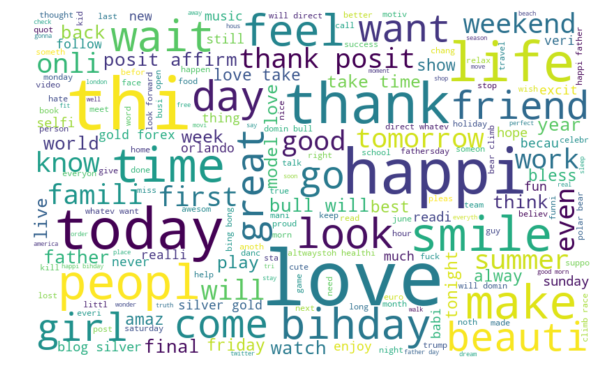

In [18]:
normal_words =' '.join([text for text in all_data['tidy_tweet'][all_data['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, background_color="white", max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### ヘイトスピーチに分類されたツイートによく出る単語

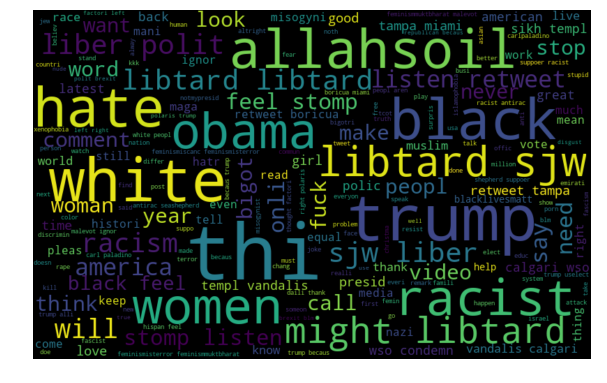

In [19]:
negative_words = ' '.join([text for text in all_data['tidy_tweet'][all_data['label'] == 1]])

wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## 4. 【単語のベクトル化】Word2Vec

In [31]:
new = []
for words in all_data["tidy_tokens"]:
    tokens = []
    for word in words:
        if word == "#":
            continue
        else:
            tokens.append(word)
    new.append(tokens)

all_data["tidy_tokens"] = new

In [25]:
from nltk import word_tokenize
all_data["tidy_tokens"] = all_data["tidy_tweet"].apply(word_tokenize)

In [32]:
all_data["tidy_tokens"].head()

0                 [when, father, dysfunct, selfish, drag, kid, into, dysfunct, run]
1    [thank, lyft, credit, caus, they, offer, wheelchair, van, disapoint, getthank]
2                                                           [bihday, your, majesti]
3                                                   [model, love, take, with, time]
4                                                       [factsguid, societi, motiv]
Name: tidy_tokens, dtype: object

In [33]:
all_data["tidy_tweet"] = all_data["tidy_tokens"].apply(lambda x: " ".join(x))

In [51]:
# word2veに流し込む
num_features = 300  
min_word_count = 40 
num_workers = 4     
context = 10        
downsampling = 1e-3 

In [ ]:
from gensim.models import word2vec
model = word2vec.Word2Vec(all_data["tidy_tokens"],\
                          workers=num_workers,\
                          size=num_features,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling)

model.init_sims(replace=True)

In [52]:
model.wv.most_similar("man")

[('babe', 0.9689621925354004),
 ('princess', 0.9639067649841309),
 ('girlfriend', 0.9612466096878052),
 ('colour', 0.9605089426040649),
 ('feet', 0.951196551322937),
 ('repost', 0.9496452808380127),
 ('photograph', 0.9455974102020264),
 ('red', 0.9438980221748352),
 ('cousin', 0.9410196542739868),
 ('bouncingbabi', 0.9392121434211731)]

In [54]:
model.wv.most_similar("love")

[('forev', 0.8800266981124878),
 ('sweet', 0.8654739856719971),
 ('friendship', 0.8577897548675537),
 ('bestfriend', 0.8424610495567322),
 ('smile', 0.8312315344810486),
 ('laughter', 0.8281192779541016),
 ('memori', 0.828048825263977),
 ('mom', 0.8237082958221436),
 ('bff', 0.8206139802932739),
 ('perfect', 0.8188551664352417)]

In [55]:
model.wv.syn0.shape

(1384, 300)

# 5. 【文章のベクトル化】Doc2Vec

In [64]:
all_data.label[:10]

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: label, dtype: float64

In [69]:
from gensim.models.doc2vec import LabeledSentence
sentences=[]
for row in all_data[["label", "tidy_tokens"]].itertuples():
    sentence = LabeledSentence(words=row[2], tags=[row[1]])
    sentences.append(sentence)

In [112]:
type(sentences[1])

gensim.models.doc2vec.LabeledSentence

In [89]:
len(sentences)

49159

In [96]:
X = []
Y = []
for i in range(0, len(sentences)):
    x = sentences[i][0]
    y = sentences[i][1]
    X.append(x)
    Y.append(y)

In [98]:
X[:2]

[['when',
  'father',
  'dysfunct',
  'selfish',
  'drag',
  'kid',
  'into',
  'dysfunct',
  'run'],
 ['thank',
  'lyft',
  'credit',
  'caus',
  'they',
  'offer',
  'wheelchair',
  'van',
  'disapoint',
  'getthank']]

In [100]:
Y[:10]

[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15,)

In [113]:
train_corpus = []
for x, y in zip(X_train, y_train):
    tup = LabeledSentence(x, y)
    train_corpus.append(tup)

In [118]:
test_corpus = []
for x, y in zip(X_test, y_test):
    tup = LabeledSentence(x, y)
    test_corpus.append(tup)

In [114]:
train_corpus

[LabeledSentence(words=['problemwithwhit', 'that', 'promot', 'lefti', 'luser', 'facist', 'gofuckyourself'], tags=[nan]),
 LabeledSentence(words=['absolut', 'love', 'train', 'today', 'lot', 'amaz', 'peopl', 'leed', 'buis', 'livelifetoful', 'success'], tags=[0.0]),
 LabeledSentence(words=['true', 'teen', 'poem', 'ness', 'quot', 'alon', 'lost', 'brokenquot', 'broken'], tags=[0.0]),
 LabeledSentence(words=['thi', 'lineup', 'fest', 'thi', 'saturday', 'henderson'], tags=[0.0]),
 LabeledSentence(words=['thank', 'therapi', 'thank', 'posit'], tags=[0.0]),
 LabeledSentence(words=['happi', 'saturday', 'guy', 'enjoythemo', 'saturday', 'foodporn', 'foodcoma', 'foodgasm'], tags=[nan]),
 LabeledSentence(words=['perfect', 'famili', 'famili', 'singhania', 'yrkkh'], tags=[nan]),
 LabeledSentence(words=['they', 'veri', 'lucki', 'kid', 'parent', 'wish', 'were', 'sta', 'over', 'again', 'school', 'day'], tags=[0.0]),
 LabeledSentence(words=['surpris', 'that', 'trump', 'chosen', 'administr', 'mere', 'basket'

In [109]:
model = Doc2Vec(size=100, min_count=2, iter=55)

In [115]:
model.build_vocab(train_corpus)

In [116]:
model.train(train_corpus, epochs=model.iter, total_examples=model.corpus_count)

In [117]:
from nltk import word_tokenize
text = "I love you so much"
text = word_tokenize(text)
model.infer_vector(text)

array([ 4.28975880e-01, -2.49514624e-01, -1.66513287e-02, -7.98672363e-02,
       -9.69706699e-02, -5.46348691e-02,  5.02255619e-01, -1.62864283e-01,
        2.44612277e-01,  5.73838949e-01,  1.15181237e-01,  5.16907163e-02,
       -8.03125277e-02,  8.60546809e-03,  3.07560414e-01,  4.92714137e-01,
       -3.53643715e-01,  1.09280169e-01, -2.71659136e-01, -2.89095417e-02,
       -2.82318234e-01,  1.34737164e-01, -7.01934025e-02, -1.39865741e-01,
       -9.23087820e-02, -1.80138201e-02, -3.33522379e-01, -3.79415937e-02,
        3.69687416e-02, -2.06949259e-03, -2.45120645e-01, -2.34663114e-01,
        5.80718741e-02, -3.95203345e-02,  2.67623007e-01, -5.66554070e-01,
       -1.53769314e-01,  5.75186670e-01, -1.61172096e-02, -5.57716303e-02,
       -1.56226754e-01, -5.85819036e-03,  1.40993148e-01, -1.13873176e-01,
       -2.15107992e-01,  2.31617242e-01, -5.82445562e-01, -1.00711122e-01,
        3.82011473e-01,  2.73089558e-01,  4.65909317e-02, -2.26825550e-01,
       -2.88371176e-01,  

##  6. 【機械学習モデリング】  Logistic Regression with doc2vec

In [120]:
train_targets, train_regressors = zip(*[(tweet.words, doc.tags[0]) for doc in train_corpus])
test_targets, test_regressors = zip(*[(doc.words, doc.tags[0]) for doc in test_corpus])

In [127]:
train_regressors

(nan,
 0.0,
 0.0,
 0.0,
 0.0,
 nan,
 nan,
 0.0,
 1.0,
 0.0,
 nan,
 1.0,
 0.0,
 0.0,
 nan,
 nan,
 0.0,
 0.0,
 nan,
 nan,
 0.0,
 0.0,
 0.0,
 0.0,
 nan,
 0.0,
 0.0,
 nan,
 nan,
 0.0,
 0.0,
 0.0,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 0.0,
 nan,
 0.0,
 nan,
 0.0,
 0.0,
 0.0,
 nan,
 0.0,
 nan,
 0.0,
 0.0,
 nan,
 0.0,
 0.0,
 0.0,
 nan,
 1.0,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 1.0,
 nan,
 nan,
 0.0,
 0.0,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 0.0,
 0.0,
 0.0,
 nan,
 0.0,
 0.0,
 0.0,
 0.0,
 nan,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 nan,
 1.0,
 nan,
 nan,
 0.0,
 nan,
 0.0,
 0.0,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 0.0,
 nan,
 0.0,
 0.0,
 nan,
 nan,
 0.0,
 0.0,
 nan,
 1.0,
 nan,
 0.0,
 0.0,
 0.0,
 nan,
 0.0,
 0.0,
 0.0,
 0.0,
 nan,
 0.0,
 0.0,
 0.0,
 nan,
 0.0,
 nan,
 nan,
 nan,
 nan,
 0.0,
 0.0,
 nan,
 nan,
 nan,
 0.0,
 0.0,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 nan,
 nan,
 0.0,
 0.0,
 0.0,
 0.0,
 nan,
 nan,
 0.0,
 0.0,
 nan,
 1.0,
 nan

In [136]:
train_regressor = []

for label in train_regressors:    
    if label == 1.0:
        label = 1
    else:
        label = 0
    train_regressor.append(label)
    
train_regressors = train_regressor

In [137]:
test_regressor = []

for label in test_regressors:    
    if label == 1.0:
        label = 1
    else:
        label = 0
    test_regressor.append(label)
    
test_regressors = test_regressor

In [138]:
X = []
for i in range(len(train_targets)):
    X.append(model.infer_vector(train_targets[i]))
train_x = np.asarray(X)

In [139]:
train_x.shape

(41785, 100)

In [140]:
Y = np.asarray(train_regressors)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y)
train_y = le.transform(Y)

In [141]:
unique, counts = np.unique(Y, return_counts=True)

print(np.asarray((unique, counts)).T)

[[    0 39875]
 [    1  1910]]


In [143]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_x, train_y)

/Users/akr712/.pyenv/versions/jupyter3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [145]:
test_list = []
for i in range(len(test_targets)):
    test_list.append(model.infer_vector(test_targets[i]))
test_x = np.asarray(test_list)
test_Y = np.asarray(test_regressors)
test_y = le.transform(test_Y)
preds = lr.predict(test_x)

In [146]:
sum(preds == test_y) / len(test_y)

0.9321941958231624